# Fluctuating environments favor extreme dormancy strategies and penalize intermediate ones

Jorge Hidalgo, Lorenzo Fant, Rafael Rubio de Casas, and Miguel A. Muñoz

## Data analysis and paper figures (stochastic eq. model)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.ndimage import gaussian_filter1d


In [2]:
# Size for a single column
fig_width = 3.375  # inches
fig_height = fig_width * (4/6)  # typical aspect ratio, for example
fontsize = 10  # same as article body

plt.rcParams.update({
    "figure.figsize": (fig_width, fig_height),
    "font.size": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": fontsize * 0.8,
    "ytick.labelsize": fontsize * 0.8,
    "legend.fontsize": fontsize * 0.8,
    "text.usetex": True,  # Use LaTeX for all text rendering
    "font.family": "serif",  # Use a serif font (matches LaTeX default)
    "font.serif": ["Computer Modern"],  # Use Computer Modern font
    })


# Fig 2 - time series

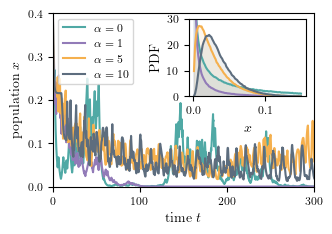

In [9]:
res = 10 # resolution

# Read the file and store the data in a list of lists
files = ['data-timeseries/output_params_timeseries_alpha0.0.dat.gz', 
         'data-timeseries/output_params_timeseries_alpha1.0.dat.gz',
         'data-timeseries/output_params_timeseries_alpha5.0.dat.gz',
         'data-timeseries/output_params_timeseries_alpha10.0.dat.gz'] 


labels = ["$\\alpha=0$", "$\\alpha=1$", "$\\alpha=5$", "$\\alpha=10$"]


colors = ['#50A9A5', '#927BB8', '#F5B04E', '#5D6D7E']


# Create figure and subplot
fig, ax = plt.subplots()

# Iterate over the files and plot the temporal series
for i, file in enumerate(files):
    data = np.loadtxt(file)
    t, x = data[::res, 0], data[::res, 1]
    ax.plot(t, x, label=labels[i], lw=1.5, color=colors[i])

# Configure the plot
ax.set_ylabel('population $x$')
ax.legend(loc='upper left')
ax.set_xlim(0, 300)
ax.set_ylim(0, 0.4)
ax.set_xticks(np.arange(0, 400, 100))
ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.set_xlabel('time $t$')


# HISTOGRAM
# Read the file and store the data in a list of lists
file_path = 'data-timeseries/pdf/output_params_timeseries_pdf_alpha_sigma_b1.05.dat.gz'
data_list = []

import gzip
import shutil
import tempfile

if file_path.endswith('.gz'):
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.dat', mode='wb')
    with gzip.open(file_path, 'rb') as f_in:
        shutil.copyfileobj(f_in, tmp)
    tmp.close()
    file_path = tmp.name


with open(file_path, 'r') as file:
    for line in file:
        if not line.startswith('#') and line.strip():
            data_list.append([float(x) for x in line.split()])

num_data = len(data_list) // 2



# Create an inset for the histogram
axins = ax.inset_axes([0.52, 0.52, 0.45, 0.45])  # [x, y, width, height] in relative coordinates

# Configure the inset
axins.set_xlabel('$x$')
axins.set_ylabel('PDF')
axins.set_ylim(0, 30)
axins.tick_params(axis='both', which='major')

# Add shaded area under each histogram curve
for i in range(num_data):
    alpha, sigma = data_list[2*i][0], data_list[2*i][1]
    hist_data = data_list[2*i+1]
    hist, bins = np.histogram(hist_data, bins=100, range=(0, 0.15), density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Smooth the histogram using a Gaussian filter
    smoothed_hist = gaussian_filter1d(hist, sigma=2)
    # Plot the smoothed histogram
    # axins.plot(bin_centers, smoothed_hist, label=f'$\\alpha={alpha}$', color=colors[i])
    axins.plot(bin_centers, hist, label=f'$\\alpha={alpha}$', color=colors[i])
    axins.fill_between(bin_centers, hist, color=colors[i], alpha=0.1)  # Add transparency to the shaded area

plt.show()
# Export the figure to a PDF file
fig.savefig("timeseries.pdf", format="pdf", bbox_inches="tight")


# Fig. 3 - mean population phase diagram

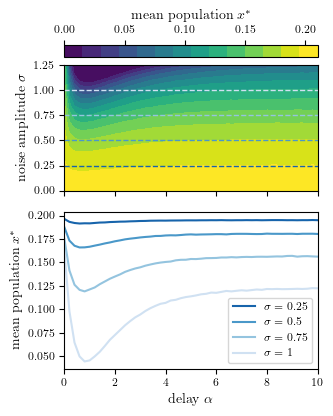

In [17]:
# Create figure and subplots with shared x-axis
fig, axs = plt.subplots(2, 1, figsize=(fig_width, 1.9*fig_height), sharex=True, tight_layout=True)

file = 'data-mean_population_diagram/output_mean_population_diagram_alpha_sigma_b1.25.dat'

data = np.loadtxt(file)
x, y, z = data[:, 0], data[:, 1], data[:, 2]

# Create the contour plot
cs = axs[0].tricontourf(x, y, z, levels=15, cmap="viridis", vmin=0, vmax=0.2)

#axs[0].tricontour(x, y, z, levels=[0], colors='black', linewidths=1)

axs[0].set_ylabel('noise amplitude $\\sigma$')
axs[0].set_xlim(0, 10)  # Limit x range
#axs[0].set_title('$b=1.05$')
cbar = fig.colorbar(cs, ax=axs[0], orientation="horizontal", label="mean population $x^*$", location="top")
cbar.set_ticks(np.arange(0, 0.25, 0.05))


y_values = np.unique(y)
y_num = len(y_values)
y_cuts = [y_values[4*y_num//5], y_values[3*y_num//5], y_values[2*y_num//5], y_values[1*y_num//5]]

# Use a red palette for the horizontal lines and plots
palette_red = sns.color_palette("Blues", len(y_cuts))

for i, (y_cut, color) in enumerate(zip(y_cuts, palette_red)):
    axs[0].axhline(y=y_cut, linestyle='--', label='$\\sigma=%g$' % y_cut, color=color, lw=1)

# Filter data and create the second plot for each y_cut
for y_cut, color in zip(y_cuts, palette_red):
    filtered_data = data[data[:, 1] == y_cut]    
    x_filtered, z_filtered = filtered_data[:, 0], filtered_data[:, 2]

    #z_smoothed = gaussian_filter1d(z_filtered, sigma=1)
    
    axs[1].plot(x_filtered, z_filtered, label='$\\sigma=%g$' % y_cut, color=color)
    #axs[1].plot(x_filtered, z_smoothed, label='$\\sigma=%.3f$' % y_cut, color=color)

axs[1].set_xlabel('delay $\\alpha$')
axs[1].set_ylabel('mean population $x^*$')
#axs[1].set_ylim(0,0.1)
#axs[1].set_yscale('log')
axs[1].legend(reversed(axs[1].get_legend_handles_labels()[0]), 
              reversed(axs[1].get_legend_handles_labels()[1]))

plt.tight_layout()

# Export the figure to a PDF file
fig.savefig("mean_population_sigma.pdf", format="pdf", bbox_inches="tight")

plt.show()


# Fig 4 - linear growth rate

In [18]:
from scipy.optimize import fsolve

def g_delay_0(alpha, b, d):
    func = lambda g : g - (b*np.exp(-g*alpha)-d)
    g_initial_guess = b-d
    return(fsolve(func, g_initial_guess)[0])

def g_delay_sigma(alpha, b, d, sigma, tau):
    g0 = g_delay_0(alpha, b, d)
    return g0 - sigma**2*0.5*tau*np.exp(-2*g0*alpha)*(1-np.exp(-2*alpha/tau))/(1+b*alpha*np.exp(-g0*alpha))*1/(1+b*alpha)

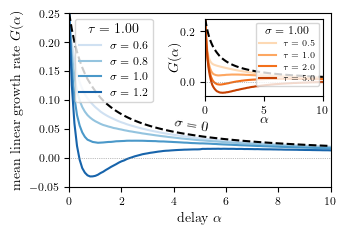

In [19]:

# List all files in the directory '1_linear' that start with 'output'
folder_1 = 'data-linear_growth_rate'
files_1 = [f for f in os.listdir(folder_1) if f.startswith('output')]

# Sort the list of files alphabetically
files_1.sort()


# Read each file and store the data in a list of dataframes
dfs = [pd.read_csv(folder_1+'/'+f, sep=" ") for f in files_1]

# Concatenate all dataframes into a single dataframe
df_combined = pd.concat(dfs, ignore_index=True)

sigma1 = [0.6, 0.8, 1., 1.2]
tau1 = 1.0

# Use a palette of blues
palette = sns.color_palette("Blues", len(sigma1))

for sigma, color in zip(sigma1, palette):
    filtered_df = df_combined[(df_combined['sigma'] == sigma) & (df_combined['tau'] == tau1)]
    plt.plot(filtered_df['alpha'], filtered_df['Gmean'], label=f'$\\sigma={sigma}$', color=color)


# Add the curve for sigma = 0
filtered_df_sigma0 = df_combined[(df_combined['sigma'] == 0) & (df_combined['tau'] == tau1)]
plt.plot(filtered_df_sigma0['alpha'], filtered_df_sigma0['Gmean'], '--k')
# Choose a location next to the value of the curve for intermediate alpha with some offset
intermediate_alpha = 4  # Intermediate value of alpha
intermediate_value = filtered_df_sigma0[filtered_df_sigma0['alpha'] == intermediate_alpha]['Gmean'].values[0]
plt.text(intermediate_alpha, intermediate_value, '$\\sigma=0$', color='black', rotation=-10)

plt.axhline(y=0, color='gray', linestyle=':', linewidth=0.5)

plt.xlabel('delay $\\alpha$')
plt.ylabel('mean linear growth rate $G(\\alpha)$')
plt.xlim(0, 10)
plt.ylim(-0.05, 0.25)
plt.legend(title="$\\tau=%.2lf$"%tau1, loc='upper left')
#plt.legend(loc='lower right', ncol=2)


sigma2 = 1.0
tau2 = [0.5, 1., 2., 5.]

# Create an inset for the previous figure
axins2 = plt.gca().inset_axes([0.52, 0.52, 0.45, 0.45])  # [x, y, width, height] in relative coordinates

# Use a palette of reds
palette_red = sns.color_palette("Oranges", len(tau2))

for i, (tau, color) in enumerate(zip(tau2, palette_red)):
    filtered_df = df_combined[(df_combined['sigma'] == sigma2) & (df_combined['tau'] == tau)]
    axins2.plot(filtered_df['alpha'], filtered_df['Gmean'], label=f'$\\tau={tau}$', color=color)

# Add the curve for sigma = 0
filtered_df_sigma0 = df_combined[(df_combined['sigma'] == 0) & (df_combined['tau'] == tau1)]
axins2.plot(filtered_df_sigma0['alpha'], filtered_df_sigma0['Gmean'], '--k')
axins2.axhline(y=0, color='gray', linestyle=':', linewidth=0.5)



axins2.set_xlabel('$\\alpha$', labelpad=-2)  # Move the xlabel up by increasing the labelpad
axins2.set_ylabel('$G(\\alpha)$', labelpad=-1)
axins2.set_xlim(0, 10)
axins2.set_ylim(top=0.25)
axins2.legend(title="$\\sigma=%.2lf$" % sigma2, loc='upper right', fontsize=6, title_fontsize=8)
# axins2.legend(loc='lower right', fontsize=4)


fig = plt.gcf()  # Get the current figure
fig.savefig("Galpha.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Fig 5 - noise induced corrections

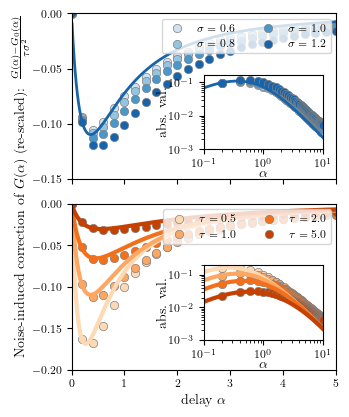

In [20]:
nsamples = 100

# List all files in the directory '1_linear' that start with 'output'
folder_1 = 'data-linear_growth_rate'
files_1 = [f for f in os.listdir(folder_1) if f.startswith('output')]


# Sort the list of files alphabetically
files_1.sort()


# Read each file and store the data in a list of dataframes
dfs = [pd.read_csv(folder_1+'/'+f, sep=" ") for f in files_1]

# Concatenate all dataframes into a single dataframe
df_combined = pd.concat(dfs, ignore_index=True)



b0 = df_combined['b0'].unique()[0]
d = df_combined['d'].unique()[0]

alpha_hres = np.linspace(0.01, 10, 1000)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(2, 1, figsize=(fig_width, 1.90*fig_height), sharex=True, tight_layout=True)

colors = sns.color_palette("Blues", len(sigma1))

for i, sigma in enumerate(sigma1):
    filtered_df = df_combined[(df_combined['sigma'] == sigma) & (df_combined['tau'] == tau1)]

    g_correction_theory = [
        -(g_delay_0(alpha, b0, d) - g_delay_sigma(alpha, b0, d, sigma, tau1)) /
        (tau1 * sigma**2) for alpha in alpha_hres
    ]
    g_correction_data = [
        -(g_delay_0(alpha, b0, d) - filtered_df['Gmean'].iloc[i]) /
        (tau1* sigma**2) for i, alpha in enumerate(filtered_df['alpha'])
    ]

    if(i==0):
        axs[0].plot(alpha_hres, g_correction_theory, ls='-', lw=2, color=colors[-1])
    axs[0].scatter(filtered_df['alpha'][::2], g_correction_data[::2], label=f'$\\sigma={sigma}$', color=colors[i], edgecolor='gray', linewidth=0.5)

    
# Plot the theory curve (last computed filtered_df is used for x-values)
# axs[0].plot(alpha_hres, g_correction_theory, ls='-', lw=2, color=colors[-1])
#axs[0].set_ylabel('$(G(\\alpha)-G_0(\\alpha))/\\tau \\sigma^2$')
axs[0].set_xlim(0,5)
axs[0].set_ylim(-0.15,0)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.05))
#axs[0].set_xscale('log')

# Add inset for log-log scale
axins0 = axs[0].inset_axes([0.5, 0.18, 0.45, 0.45])  # [x, y, width, height] in relative coordinates
axins0.plot(alpha_hres, -np.array(g_correction_theory), ls='-', lw=2, color=colors[-1])
for i, sigma in enumerate(sigma1):
    filtered_df = df_combined[(df_combined['sigma'] == sigma) & (df_combined['tau'] == tau1)]
    g_correction_data = [
        (g_delay_0(alpha, b0, d) - filtered_df['Gmean'].iloc[i]) /
        (tau1 * sigma**2) for i, alpha in enumerate(filtered_df['alpha'])
    ]
    axins0.scatter(filtered_df['alpha'][::2], g_correction_data[::2], label=f'$\\sigma={sigma}$', edgecolor='gray', linewidth=0.5, color=colors[i])

axins0.set_xscale('log')
axins0.set_yscale('log')
axins0.set_ylim(bottom=0.001)
axins0.set_xlabel('$\\alpha$', labelpad=-1)
axins0.set_ylabel('abs. val.', labelpad=0)
axins0.set_xlim(0.1,10)

#axs[0].legend(title=f"$\\tau={tau1}$", loc=(0.75,0.05)) 
#axs[0].legend(title=f"$\\tau={tau1}$", loc='lower right') 
axs[0].legend(loc='upper right', ncol=2) 

palette_oranges = sns.color_palette("Oranges", len(tau2))

for idx, tau in enumerate(tau2):
    filtered_df = df_combined[(df_combined['sigma'] == sigma2) & (df_combined['tau'] == tau)]
    g_correction_theory = [
        -(g_delay_0(alpha, b0, d) - g_delay_sigma(alpha, b0, d, sigma2, tau)) /
        (tau * sigma2**2) for alpha in alpha_hres
    ]
    g_correction_data = [
        -(g_delay_0(alpha, b0, d) - filtered_df['Gmean'].iloc[i]) /
        (tau * sigma2**2) for i, alpha in enumerate(filtered_df['alpha'])
    ]

    axs[1].scatter(filtered_df['alpha'][::2], g_correction_data[::2], label=f'$\\tau={tau}$', color=palette_oranges[idx], edgecolor='gray', linewidth=0.5)

    axs[1].plot(alpha_hres, g_correction_theory, ls='-', lw=3, color=palette_oranges[idx])

axs[1].set_xlabel('delay $\\alpha$')
fig.text(-0.02, 0.55, 'Noise-induced correction of $G(\\alpha)$ (re-scaled): $\\frac{G(\\alpha)-G_0(\\alpha)}{\\tau \\sigma^2}$', va='center', rotation='vertical')

axs[1].set_ylim(-0.2,0)



# Add inset for log-log scale
axins1 = axs[1].inset_axes([0.5, 0.18, 0.45, 0.45])  # [x, y, width, height] in relative coordinates
for idx, tau in enumerate(tau2):
    filtered_df = df_combined[(df_combined['sigma'] == sigma2) & (df_combined['tau'] == tau)]

    g_correction_theory = [
        (g_delay_0(alpha, b0, d) - g_delay_sigma(alpha, b0, d, sigma2, tau)) /
        (tau * sigma2**2) for alpha in alpha_hres
    ]

    g_correction_data = [
        (g_delay_0(alpha, b0, d) - filtered_df['Gmean'].iloc[i]) /
        (tau * sigma2**2) for i, alpha in enumerate(filtered_df['alpha'])
    ]
    axins1.plot(alpha_hres, g_correction_theory, ls='-', lw=3, color=palette_oranges[idx])
    axins1.scatter(filtered_df['alpha'][::2], g_correction_data[::2], label=f'$\\tau={tau}$', color=palette_oranges[idx], edgecolor='gray', linewidth=0.5)

axins1.set_xscale('log')
axins1.set_xlabel('$\\alpha$', labelpad=-1)
axins1.set_ylabel('abs. val.', labelpad=0)
axins1.set_ylim(bottom=0.001, top=0.2)
axins1.set_xlim(0.1, 10)
axins1.set_yscale('log')

#axs[1].legend(title=f"$\\sigma={sigma2}$", loc='lower right', ncols=2)  # Legend with title for tau
axs[1].legend(loc='upper right', ncols=2)  # Legend with title for tau


fig.savefig("g_correction.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Fig. 6 - mean extinction times

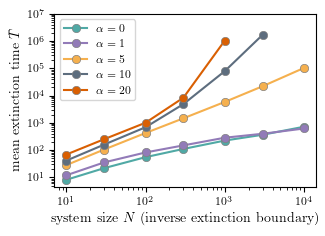

In [24]:
# File to plot
file = 'data-mean_ext_times/output_params_alpha_N_b1.05_tau1.0_sigma0.5.dat'
otherfiles = []

alpha_values = [0, 1, 5, 10, 20]
colors = ['#50A9A5', '#927BB8', '#F5B04E', '#5D6D7E', '#D95F02']


# Read the file and extract data
data = np.loadtxt(file)
# Read the additional files and store the data in a list
other_data = [np.loadtxt(f) for f in otherfiles]

# Merge data and all arrays in other_data into a single array
data = np.vstack([data] + other_data)



w, x, y, z = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
z = np.nan_to_num(z, nan=0)



# Create figure
fig, ax = plt.subplots()

# Filter data and plot
for i, alpha in enumerate(alpha_values):
    filtered_data = data[data[:, 1] == alpha]
    if alpha == 10:
        filtered_data = filtered_data[:-1]
    ax.plot(filtered_data[:, 2], filtered_data[:, 3], label=f'$\\alpha={int(alpha)}$', marker='o', color=colors[i], markeredgecolor='gray', markeredgewidth=0.5)

# Configure the plot
# ax.axhline(y=1e7, color='k', linestyle=':')
ax.set_xlabel('system size $N$ (inverse extinction boundary)')
ax.set_ylabel('mean extinction time $\\bar{T}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=1e7)
ax.legend(loc='upper left')

# Export the figure to a file
fig.savefig("mean_ext_time_vs_N.pdf", format="pdf", bbox_inches="tight")

plt.show()


## Fig. 7 - trade-off

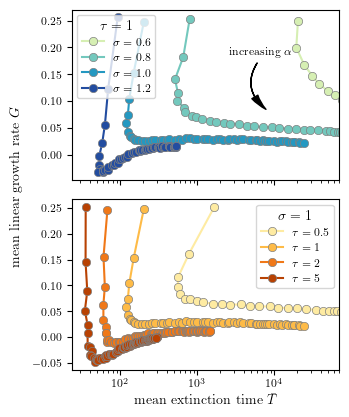

In [25]:
import os
import pandas as pd


# List all files in the directory '6_tradeoff' that start with 'output'
folder_6 = 'data-trade_off'
files6 = [f for f in os.listdir(folder_6) if f.startswith('output')]

files6.sort()
data6 = [pd.read_csv(folder_6+'/'+f, sep=" ", index_col=False, header=0) for f in files6]
data6 = pd.concat(data6, ignore_index=True)

tmax = 1e5

sigma1 = [0.6, 0.8, 1., 1.2]
tau1 = 1.

sigma2 = 1.
tau2 = [0.5, 1, 2, 5]

b0 = 1.25

# Create a figure with two subplots (two rows)
fig, axs = plt.subplots(2, 1, figsize=(fig_width, 1.90*fig_height), sharex=True, tight_layout=True)

# Main plot
palette_blue = sns.color_palette("YlGnBu", len(sigma1))
for sigma, color in zip(sigma1, palette_blue):
    data6_filtered = data6[(data6['tau'] == tau1) & (data6['sigma'] == sigma) & (data6['b0'] == b0)]
    axs[0].plot(data6_filtered['Tmean'], data6_filtered['Gmean'], label=f'$\\sigma={sigma}$', marker='o', color=color, markeredgecolor='gray', markeredgewidth=0.5)

axs[0].axvline(x=tmax, color='k', linestyle='--', lw=0.5)
axs[0].set_xscale('log')
# axs[0].set_ylabel('av. growth rate $G$')
# axs[0].set_xlabel('av. extinction time $\\bar T$')
axs[0].legend(title="$\\tau=1$", loc='upper left')
axs[0].annotate('increasing $\\alpha$', xy=(tmax/12, axs[0].get_ylim()[1]*0.3), 
                xytext=(tmax/15, axs[0].get_ylim()[1]*0.7),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.01, headwidth=5, connectionstyle="arc3,rad=+0.5"),
                ha='center', va='center', fontsize=8)

# Second panel (formerly inset)
palette_reddish = sns.color_palette("YlOrBr", len(tau2))
for c, (tau, color) in enumerate(zip(tau2, palette_reddish)):
    data6_filtered = data6[(data6['tau'] == tau) & (data6['sigma'] == sigma2) & (data6['b0'] == b0)]
    axs[1].plot(data6_filtered['Tmean'], data6_filtered['Gmean'], label=f'$\\tau={tau}$', marker='o', color=color, markeredgecolor='grey', markeredgewidth=0.5)

axs[1].axvline(x=tmax, color='k', linestyle='--', lw=0.5)
axs[1].set_xscale('log')
# axs[1].set_ylabel('$G$')
axs[1].set_xlabel('mean extinction time $\\bar T$')
axs[1].legend(title="$\\sigma=1$", loc='upper right', fontsize=8)
fig.text(-0.02, 0.55, 'mean linear growth rate $G$', va='center', rotation='vertical')

axs[1].set_xlim(right=7e4)

# Export the figure to a PDF file
fig.savefig("tradeoff_analysis.pdf", format="pdf", bbox_inches="tight")


plt.show()
